In [1]:
import re
from typing import List
from io import StringIO
from html.parser import HTMLParser
import pymorphy2
from tqdm import tqdm
import gensim
import pandas as pd
import logging
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
import json

In [2]:
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
import seaborn as sns

In [ ]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [ ]:
# !pip install nltk

In [ ]:
# nltk.download('stopwords')

In [ ]:
#from googletrans import Translator
#translator = Translator()

In [4]:
# https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff
# https://www.machinelearningmastery.ru/journey-to-the-center-of-multi-label-classification-384c40229bff/#

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

GROUPING_SPACE_REGEX = re.compile(r'([^\w]|[+])', re.UNICODE)

dir_with_files = './lab05data/'

train_file_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
#train_file_numbers =  [1, 2,    4, 5, 6, 7, 8,            12,     14, 15, 16, 17, 18, 19, 20]
# возможно, не все документы нужны - №3 на английском, № 9-10 дубли
# но на bag of words это не влияет
train_file_pattern = dir_with_files + 'base_{0}.txt'
test_file_numbers = [2561, 2049, 4, 2565, 2562, 2062, 3600, 3603, 3588, 534, 3607, 24, 25, 3612, 3102, 2591, 3804, 3627, 1580, 46, 1074, 2100, 3125, 56, 1593, 2485, 2621, 63, 3139, 2316, 610, 2121, 1098, 1099, 588, 2126, 2639, 88, 2140, 607, 1634, 2067, 612, 3175, 3178, 531, 1647, 1136, 1137, 1139, 1146, 1151, 22, 1710, 2692, 1160, 1674, 1560, 3729, 623, 3224, 153, 2206, 1183, 160, 3235, 3748, 684, 1651, 1711, 30, 1714, 2079, 695, 2232, 698, 189, 1227, 1025, 711, 3784, 2253, 2763, 3788, 1741, 2255, 1232, 3283, 383, 2775, 2265, 1829, 1244, 3300, 1767, 1257, 1320, 1747, 3830, 1152, 1279, 3030, 913, 3332, 1798, 2311, 386, 1289, 3340, 269, 1806, 274, 1425, 789, 2863, 1305, 2332, 800, 1825, 2339, 292, 293, 2855, 3368, 562, 2861, 3886, 2351, 2864, 307, 2356, 822, 1019, 3722, 2101, 3387, 2688, 829, 3904, 833, 2279, 3398, 2887, 336, 337, 3473, 854, 3420, 2398, 3426, 3939, 3940, 357, 2918, 1387, 2924, 879, 3442, 1396, 2421, 2427, 1407, 1345, 2438, 1928, 1419, 2456, 1054, 2030, 1937, 402, 2628, 2968, 409, 1437, 1956, 421, 1963, 943, 2481, 3509, 955, 2635, 2496, 455, 972, 3025, 1188, 3542, 3544, 3550, 482, 3699, 2812, 2534, 3566, 1521, 3570, 1525, 2043]
test_file_pattern = dir_with_files + 'test_{0}.txt'

In [5]:
# стырено здесь: https://stackoverflow.com/questions/753052/strip-html-from-strings-in-python
# убирает HTML-тэги из текста
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()

    def handle_data(self, d):
        self.text.write(d)

    def get_data(self):
        return self.text.getvalue()


def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [6]:
def read_text_files_to_pandas(num_of_files: List[int], file_pattern: str):
    """Самодельная читалка файлов.
    Читает их и заполняет ими pd.DataFrame

    :param num_of_files: Список номеров файлов
    :param file_pattern: Шаблон пути к файлу. В него подставляются номера из первого параметра.
    """
    cnt = 0
    df = pd.DataFrame(columns=['id', 'text'])  # колонки в результирующем датафрейме
    for idx in tqdm(num_of_files):
        file_name = file_pattern.format(idx)
        with open(file=file_name, mode='rt') as file:
            txt = file.read()
            txt = strip_tags(txt)
            txt = txt.lower().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
            txt = re.sub(r'[\.\,\;\!\?\(\)\[\]\:\\\/\-]+', ' ', txt)
            txt = re.sub(r'[\s]+', ' ', txt)
            df.loc[cnt] = [idx, txt]
        cnt += 1
    return df

In [7]:
# куски кода из лекции - для превращения текста в мешок слов
def simple_word_tokenize(text: str, _split=GROUPING_SPACE_REGEX.split):
    return [t for t in _split(text.lower()) if t and not t.isspace()]


def token_r(m: pymorphy2.MorphAnalyzer, text: str):
    words = simple_word_tokenize(text)
    return [m.parse(x)[0].normal_form for x in words if len(x) >= 4]

### Готовим наши массивы

In [8]:
# готовим наши массивы
df = read_text_files_to_pandas(train_file_numbers, train_file_pattern)
df_test = read_text_files_to_pandas(test_file_numbers, test_file_pattern)

100%|██████████| 200/200 [00:01<00:00, 172.75it/s]


In [10]:
df.head()

,id,text
0,1,ищем прекрасного программиста 1с в дружный отд...
1,2,предлагаем уникальную возможность присоединить...
2,3,netcracker technology corp a large software de...
3,4,senior java software engineer в отдел разработ...
4,5,netcracker technology corp a large software de...


In [11]:
df_test.head()

,id,text
0,2561,мы ищем талантливых и целеустремленных специал...
1,2049,чем придется заниматься интаро — лидер в разра...
2,4,обязанности проектирование и реализация web ин...
3,2565,ищем опытных разработчиков под android для реа...
4,2562,работа в германии молодая софт компания evolut...


In [ ]:
df_test

In [ ]:
# переводим исходные тексты на русский (есть лимит в сколько-то символов в день)
#translations = translator.translate(df['text'].tolist(), src='en', dest='ru')
#translated = [translation.text for translation in translations]
#df['text'] = translated

In [12]:
m = pymorphy2.MorphAnalyzer()

# в обучающем наборе текстов нормализовали все слова (BOW = Bag Of Words)
bow_txts = [token_r(m, str(txt)) for txt in tqdm(df.text)]
bow_txts_test = [token_r(m, str(txt)) for txt in tqdm(df_test.text)]

2020-11-09 14:30:06,420 : INFO : Loading dictionaries from /home/kit-kat/.virtualenvs/NovikovMS Lab1/lib/python3.6/site-packages/pymorphy2_dicts_ru/data
2020-11-09 14:30:06,526 : INFO : format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345
100%|██████████| 200/200 [00:08<00:00, 23.54it/s]


In [13]:
# строим словарь по неочищенным текстам
wrd_index = gensim.corpora.Dictionary(bow_txts + bow_txts_test)

2020-11-09 14:30:19,585 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-11-09 14:30:19,648 : INFO : built Dictionary(3950 unique tokens: ['база', 'бухгалтерия', 'вторник', 'данные', 'делать']...) from 220 documents (total 25382 corpus positions)


In [14]:
# вычисляем бесполезные слова
no_above = 0.6
buzzwords = {}
for key, val in wrd_index.items():
    if wrd_index.dfs[key] > no_above * wrd_index.num_docs:
        buzzwords[val] = wrd_index.dfs[key]/wrd_index.num_docs
buzzwords

{'работа': 0.9409090909090909,
 'опыт': 0.7454545454545455,
 'условие': 0.6590909090909091,
 'требование': 0.7681818181818182,
 'обязанность': 0.6590909090909091}

In [15]:
# получаем стоп-слова
ru_stopwords = set(stopwords.words('russian')).union(buzzwords.keys())

In [16]:
# убираем из bagofwords стоп-слова
bow_txts_nostop = [list(set(txt).difference(ru_stopwords)) for txt in tqdm(bow_txts)]  
bow_txts_test_nostop = [list(set(txt).difference(ru_stopwords)) for txt in tqdm(bow_txts_test)]

100%|██████████| 200/200 [00:00<00:00, 26675.38it/s]


In [17]:
# построили словарь по очищенным текстам (только по train выборке!!!)
wrd_index_nostop = gensim.corpora.Dictionary(bow_txts_nostop)  

2020-11-09 14:31:42,676 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-11-09 14:31:42,690 : INFO : built Dictionary(998 unique tokens: ['база', 'бухгалтерия', 'вторник', 'данные', 'делать']...) from 20 documents (total 2318 corpus positions)


In [18]:
# в обучающих текстах слова заменены на индексы слов из словаря их количество в тексте
corpus = [wrd_index_nostop.doc2bow(txt) for txt in tqdm(bow_txts_nostop)]
corpus_test = [wrd_index_nostop.doc2bow(txt) for txt in tqdm(bow_txts_test_nostop)]

100%|██████████| 200/200 [00:00<00:00, 6227.21it/s]


## Без выделения тематик из текстов

#### Создаём массивы из 0/1 для подсчёта корреляции

In [21]:
# количество столбцов = количеству оставшихся уникальных слов в словаре после вычета стоп-слов
num_of_topics = len(wrd_index_nostop)
words_only_columns = ['t_{0}'.format(i) for i in range(num_of_topics)]
columns = ['id', 'df_num'] + words_only_columns

# собрали dataframe'ы - в строках - номера текстов, в столбцах - номера слов в словаре. На пересечении - 0 или 1.
df_bow_orig = pd.DataFrame(columns=columns)
df_bow_unknown = pd.DataFrame(columns=columns)

#### Заполняем массивы 0/1

In [22]:
for i in range(len(corpus)):
    lst = [0]*num_of_topics
    for k, v in corpus[i]:
        lst[k] = v
    df_bow_orig.loc[i] = [train_file_numbers[i], 1] + lst  # заполняем df для кластерного анализа

In [23]:
for i in range(len(corpus_test)):
    lst = [0]*num_of_topics
    for k, v in corpus_test[i]:
        lst[k] = v
    df_bow_unknown.loc[i] = [test_file_numbers[i], 0] + lst  # заполняем df для кластерного анализа

<AxesSubplot:>

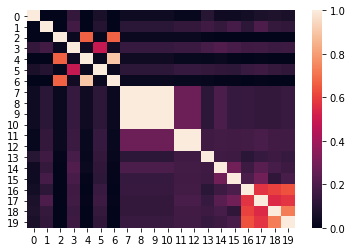

In [26]:
# это, чтобы посмотреть корреляции train * train
cos_matrix = cosine_similarity(df_bow_orig[words_only_columns], 
                               df_bow_orig[words_only_columns])
cos_matrix.shape

sns.heatmap(cos_matrix)

In [27]:
# строим корреляционную матрицу: тексты из test (в строках) vs. тексты из train (в столбцах)
cos_matrix = cosine_similarity(df_bow_unknown[words_only_columns], 
                               df_bow_orig[words_only_columns])
cos_matrix.shape

(200, 20)

In [28]:
df_bow_unknown[words_only_columns].shape

(200, 998)

In [29]:
df_bow_orig[words_only_columns].shape

(20, 998)

In [30]:
com_m = pd.DataFrame(cos_matrix)

In [31]:
# выводим матрицу корреляции текстов( в строках test, в столбцах - train)
com_m['cos_max'] = com_m[list(range(cos_matrix.shape[1]))].max(axis=1)  # максимум по строке
com_m['cos_sum'] = com_m[list(range(cos_matrix.shape[1]))].sum(axis=1)  # сумма по строке
com_m

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,cos_max,cos_sum
0,0.095077,0.161479,0.024175,0.237375,0.028242,0.172224,0.026856,0.127661,0.127661,0.127661,...,0.117170,0.119864,0.159120,0.227611,0.230144,0.189453,0.192635,0.211021,0.237375,2.820260
1,0.087287,0.177900,0.000000,0.252796,0.012964,0.237171,0.012328,0.222683,0.222683,0.222683,...,0.227093,0.144433,0.252326,0.290227,0.190160,0.241571,0.197659,0.170941,0.290227,3.612684
2,0.022473,0.244282,0.000000,0.269321,0.000000,0.232621,0.000000,0.217262,0.217262,0.217262,...,0.233874,0.205410,0.177799,0.251070,0.206717,0.189076,0.203561,0.199517,0.269321,3.538644
3,0.059235,0.201211,0.015062,0.177468,0.017595,0.091971,0.016732,0.174978,0.174978,0.174978,...,0.178444,0.149357,0.324443,0.283614,0.129046,0.183608,0.211793,0.139205,0.324443,3.057140
4,0.000000,0.189466,0.020261,0.111406,0.023669,0.123718,0.022507,0.085592,0.085592,0.085592,...,0.087287,0.125570,0.048493,0.169562,0.077152,0.105851,0.056980,0.062419,0.189466,1.653997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.120060,0.122347,0.030528,0.239801,0.035663,0.170877,0.033913,0.112845,0.112845,0.112845,...,0.131519,0.141901,0.127866,0.159678,0.188902,0.172781,0.143091,0.094049,0.239801,2.495875
196,0.118470,0.100605,0.000000,0.153806,0.000000,0.168613,0.000000,0.079536,0.079536,0.079536,...,0.113555,0.130687,0.090123,0.078782,0.157723,0.183608,0.169435,0.185606,0.185606,2.082711
197,0.057735,0.078446,0.000000,0.092253,0.000000,0.089642,0.000000,0.031009,0.031009,0.031009,...,0.031623,0.072787,0.105409,0.030715,0.055902,0.076696,0.110096,0.060302,0.110096,1.017265
198,0.076139,0.077589,0.000000,0.121660,0.000000,0.098514,0.000000,0.020447,0.020447,0.020447,...,0.083406,0.071992,0.023168,0.040505,0.092151,0.118002,0.145191,0.059643,0.145191,1.173152


In [32]:
# делим тексты на две кучки - выше среднего по выборке и ниже среднего по выборке
distr = pd.DataFrame(data=cos_matrix).sum(axis=1)  # столбец с суммами корреляций вытаскиваем отдельно
df_bow_unknown['cosine'] = distr  
df_bow_unknown['flag'] = 1*(df_bow_unknown['cosine'] > distr.mean())  # проверка на больше/меньше средней по выборке

In [33]:
df_bow_unknown

,id,df_num,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,...,t_990,t_991,t_992,t_993,t_994,t_995,t_996,t_997,cosine,flag
0,2561,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,2.820260,1
1,2049,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,3.612684,1
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.538644,1
3,2565,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,3.057140,1
4,2562,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.653997,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,3566,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2.495875,1
196,1521,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.082711,0
197,3570,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.017265,0
198,1525,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.173152,0


In [34]:
# пороговое значение
distr.mean()

2.412251975948125

<AxesSubplot:ylabel='Count'>

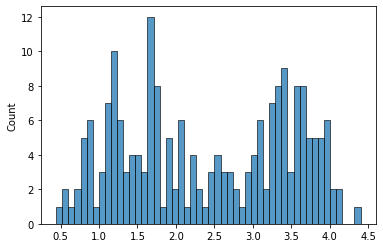

In [36]:
# выводим сумму корреляций
sns.histplot(distr, bins=50)

In [37]:
threshhold = distr.mean()  # distr.mean()
defined = list(map(int, df_bow_unknown.loc[df_bow_unknown['cosine'] >= threshhold, 'id'].to_list()))
other = list(map(int, df_bow_unknown.loc[df_bow_unknown['cosine'] < threshhold, 'id'].to_list()))

In [38]:
print('len(defined) = {0}, len(other) = {1}'.format(len(defined), len(other)))

len(defined) = 101, len(other) = 99


In [39]:
# сохранили файл. Его нужно положить на сервер и отдать чекеру
with open(file='lab05.json', mode='wt') as file:
    file.write(json.dumps({'defined': defined, 'other': other}) + '\n')